In [1]:
import os
from datetime import datetime

from classes.prices.AVPrice import AVPrice
from classes.datasets.Technical_Diffshift import Technical_Diffshift
from classes.traders.Binary_Trader import Binary_Trader
from classes.allocators.Mean_LERP import Mean_LERP
from classes.classifiers.Sklearn_GSCV import Sklearn_GSCV
from classes.classifiers.Benchmark import Benchmark

from classes.RunFunctions import *

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from datetime import datetime
from ta import add_all_ta_features
import pandas as pd
import requests
import math
import numpy as np
import time
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import matplotlib.pyplot as plt
from statistics import mean

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
TECHNICAL_COLS = ['volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [3]:
#plots============================================================================
def GenerateLineChart(df, column, ax, title): 
    ax.set_title(title)
    sns.lineplot(data = df, x = 'date', y = column, ax = ax)

def GenerateBarChart(df, column, ax, title): 
    ax.set_title(title)
    sns.barplot(data = df, x = 'date', y = column, ax = ax)
    
def GenerateHistogram(df, column, ax, title):
    ax.set_title(title)
    data = df[column].dropna()
    sns.kdeplot(data,bw=0.25,ax=ax, fill=True)
    ax.axvline(0, 0, 1)
    color = 'green'
    if mean(data)<0:
        color = 'red'
    ax.axvline(mean(data), 0, 1, color = color)
    m = max(abs(min(data)), abs(max(data)))
    ax.axvline(-m, 0, 0)
    ax.axvline(m, 0, 0)

def GenerateSummaryParCoords(allocator_returns, allocators, prices, datasets, classifiers, predictors):
    combos, combos['prices'], combos['datasets'], combos['classifiers'], combos['traders'], combos['allocators'], combos['std_daily'], combos['mean_daily'] = {},[],[],[],[],[],[],[]
    for a in allocator_returns:
        for p in prices:
            for d in datasets:
                if not CheckKeys(False, datasets[d].included, datasets[d].excluded, p):
                    continue
                for c in classifiers:
                    if not CheckKeys(False, classifiers[c].included, classifiers[c].excluded, p, d):
                        continue
                    for t in predictors:
                        if not CheckKeys(False, predictors[t].included, predictors[t].excluded, p, d, c):
                            continue
                        if CheckKeys(False, allocators[a].included, allocators[a].excluded, p, d, c, t):
                            combos['prices'].append(p)
                            combos['datasets'].append(d + '_' + p)
                            combos['classifiers'].append(c + '_' + d + '_' + p)
                            combos['traders'].append(t + '_' + c + '_' + d + '_' + p)
                            combos['allocators'].append(a)
                            combos['std_daily'].append(np.std(allocator_returns[a]['weighted_pal']))
                            combos['mean_daily'].append(np.mean(allocator_returns[a]['weighted_pal']))

    items = []
    for key in ['prices', 'datasets', 'classifiers', 'traders', 'allocators']:
        ticktext = list(np.unique(np.array((combos[key]))))
        ticktext.sort(reverse=True)
        tickvals = list(range(0,len(ticktext)))
        values = []
        for p in combos[key]:
            values.append(ticktext.index(p))
        items.append({'tickvals':tickvals,'label':key,'ticktext':ticktext, 'values':values})
    for key in ['mean_daily']: # 'std_daily'
        items.append({'label':key,'values':combos[key]})

    fig = go.Figure(data= go.Parcoords(line = dict(colorscale = 'Electric'), dimensions = items))
    fig.show()

#allocator============================================================================
def GeneratePortfolioReturns(portfolio_result, rolls = [3, 5]):
    df = portfolio_result[['date','weight','weighted_pal']]
    df = df.groupby(['date']).sum().reset_index()
    for roll in rolls:
        df[str(roll) + 'D_mean'] = df['weighted_pal'].rolling(roll).mean()
        df[str(roll) + 'D_cumprod'] = (1 + df['weighted_pal']).rolling(roll).apply(np.prod, raw=True) - 1
    return df

def GenerateInstructions(date, portfolio_result):
    df = portfolio_result[(portfolio_result['date'] == date)]
    df = df[['date','dataset','exit_method','bought_at','amount']]
    df = df.groupby(['date','dataset','exit_method','bought_at']).sum().reset_index()
    return df

#classifier====================================================================
def GetClassifierDatasetRunRange(start_date, end_date, dataset, classifier_data):
    run_ranges = []
    try:
        start_ind, end_ind = dataset.index.get_loc(start_date), dataset.index.get_loc(end_date)
    except:
        print('dates not found in underlying dataset, aborting generating classifier data')
        return
    if start_ind > end_ind:
        print('start_date is not earlier than end date, aborting generating classifier data')
    elif len(classifier_data) == 0:
        print('no file, running for full range: ' + start_date + ' - ' + end_date)
        run_ranges.append(range(start_ind, end_ind))
    else:
        existing_data = classifier_data[0]
        existing_sdate, existing_edate = existing_data.index[0], existing_data.index[-1]
        existing_start_ind, existing_end_ind = dataset.index.get_loc(existing_sdate), dataset.index.get_loc(existing_edate)
        if end_ind <= existing_end_ind and start_ind >= existing_start_ind:
            print('date range exists fully in file, not running any range')
        elif end_ind < existing_start_ind:
            print('existing file starts after specified end date - running up to start of file: ' + start_date + ' -> ' + existing_sdate)
            run_ranges.append(range(start_ind, existing_start_ind))
        elif start_ind > existing_end_ind:
            print('existing file ends before specified start date - running from end of file: ' + existing_edate + ' -> ' + end_date)
            run_ranges.append(range(existing_end_ind, end_ind))
        else: 
            if start_ind < existing_start_ind:
                print('running up to start of file: ' + start_date + ' -> ' + existing_sdate)
                run_ranges.append(range(start_ind, existing_start_ind))
            if end_ind > existing_end_ind+1:
                print('running from end of file: ' + existing_edate + ' -> ' + end_date)
                run_ranges.append(range(existing_end_ind, end_ind))
    return run_ranges  

def CheckKeys(Debug, included, excluded, price='',dataset='',classifier='',trader='',allocator=''):
    if price != '' and 'prices' in included and len(included['prices']) > 0 and price not in included['prices']:
        if Debug: print('price: ' + price + ' not in included: ' + str(included['prices']))
        return False
    if dataset != '' and 'datasets' in included and len(included['datasets']) > 0 and dataset not in included['datasets']:
        if Debug: print('dataset: ' + dataset + ' not in included: ' + str(included['datasets']))
        return False
    if classifier != '' and 'classifiers' in included and len(included['classifiers']) > 0 and classifier not in included['classifiers']:
        if Debug: print('classifier: ' + classifier + ' not in included: ' + str(included['classifiers']))
        return False
    if trader != '' and 'traders' in included and len(included['traders']) > 0 and trader not in included['traders']:
        if Debug: print('trader: ' + trader + ' not in included: ' + str(included['traders']))
        return False
    if allocator != '' and 'allocators' in included and len(included['allocators']) > 0 and allocator not in included['allocators']:
        if Debug: print('allocator: ' + allocator + ' not in included: ' + str(included['allocators']))
        return False
    
    if price != '' and 'prices' in excluded and len(excluded['prices']>0) and price in excluded['prices']:
        if Debug: print('price: ' + price + ' in excluded: ' + str(excluded['prices']))
        return False
    if dataset != '' and 'datasets' in excluded and len(excluded['datasets']) > 0 and dataset in excluded['datasets']:
        if Debug: print('dataset: ' + dataset + ' in included: ' + str(excluded['datasets']))
        return False
    if classifier != '' and 'classifiers' in excluded and len(excluded['classifiers']) > 0 and classifier in excluded['classifiers']:
        if Debug: print('classifier: ' + classifier + ' in excluded: ' + str(excluded['classifiers']))
        return False
    if trader != '' and 'traders' in excluded and len(excluded['traders']) > 0 and trader in excluded['traders']:
        if Debug: print('trader: ' + trader + ' in excluded: ' + str(excluded['traders']))
        return False
    if allocator != '' and 'allocators' in excluded and len(excluded['allocators']) > 0 and allocator in excluded['allocators']:
        if Debug: print('allocator: ' + allocator + ' in excluded: ' + str(excluded['allocators']))
        return False
    
    return True


<h1>Data Definition</h1>

In [30]:
prices = {'500.PAR': AVPrice('500.PAR'),
          'NDAQ': AVPrice('NDAQ'),
          'DAX': AVPrice('DAX'),
          'AAPL': AVPrice('AAPL'),
          'MSFT': AVPrice('MSFT'),
          'AMZN': AVPrice('AMZN'),
          'FB': AVPrice('FB'),
          'GOOGL': AVPrice('GOOGL'),
          'GOOG': AVPrice('GOOG'),
          'TSLA': AVPrice('TSLA'),
          'NVDA': AVPrice('NVDA')}

datasets = {'D1':Technical_Diffshift(#label='500.PAR', 
                              symbols=['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG'], 
                              pivot_cols = ['open','high','low','close','volume'], 
                              pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]},
                              technical_cols = ['volume_adi'],
                              included = {'prices':['500.PAR','NDAQ']}),
           }

classifiers = {'AL': Benchmark('long', included={'datasets':['D1']}),
               'M1': Sklearn_GSCV(150,400,0.33,MLPClassifier(random_state=42), param_grid={'hidden_layer_sizes':[(56,28),(28,14),(64,32,16)],'max_iter':[100,200],'activation':['relu'],'solver':['adam'],'learning_rate_init':[0.001,0.01]}),
               }
                #'M2': (SVC(gamma=2),{'C':[0.025,0.25,1]}),
                #'M3': (DecisionTreeClassifier(),{'max_depth':[5,10]}),
                #'M4': (RandomForestClassifier(),{'max_depth':[5,10], 'n_estimators':[5,10],'max_features':[1]})}

predictors = {'T1': Binary_Trader(threshold=0.0025, exit_method='at_close'),
              'T2': Binary_Trader(threshold=0.0025, exit_method='capture_gains', capture_thresh = 0.0075, excluded={'classifiers':['AL']}),
              'T3': Binary_Trader(threshold=0.0025, exit_method='at_close', trade_longs = False, excluded={'classifiers':['AL']}),
              'T4': Binary_Trader(threshold=0.0025, exit_method='capture_gains', capture_thresh = 0.0075, trade_longs = False, excluded={'classifiers':['AL']})}

allocators = {'A1': Mean_LERP(mean_periods = 5, min_lerp = 0.25, max_lerp = 1, excluded={'classifiers':['AL']}),
              'A2': Mean_LERP(mean_periods = 5, min_lerp = 0.25, max_lerp = 1, included={'traders':['T3','T4']}),
              'BM_SAP': Mean_LERP(mean_periods = 5, min_lerp = 0.25, max_lerp = 1, included={'classifiers':['AL'],'prices':['500.PAR']}),
              'BM_DAQ': Mean_LERP(mean_periods = 5, min_lerp = 0.25, max_lerp = 1, included={'classifiers':['AL'],'prices':['NDAQ']}),
             }

<h1>Run Parameters</h1>

In [31]:
runid = '20220212'

start_date, end_date = '2021-09-28', '2021-09-30'

#use start and end date
classifier_load_mode = 'file_or_generate' #'file', 'generate', 'file_or_generate'
classifier_save_rslt = True

#use start and end date
trader_load_mode = 'generate' #'file', 'generate'
trader_save_rslt = True

allocator_load_mode = 'generate' #'file', 'generate'
allocator_save_rslt = True

<h1> Prices </h1>

In [32]:
price_data = RunPriceData(runid, prices, start_date, end_date, 'file_or_generate', save=True)

loading price: 500.PAR, file is up to date: 2022-02-11 >= 2021-09-30
loading price: NDAQ, file is up to date: 2022-02-11 >= 2021-09-30
loading price: DAX, file is up to date: 2022-02-11 >= 2021-09-30
loading price: AAPL, file is up to date: 2022-02-11 >= 2021-09-30
loading price: MSFT, file is up to date: 2022-02-11 >= 2021-09-30
loading price: AMZN, file is up to date: 2022-02-11 >= 2021-09-30
loading price: FB, file is up to date: 2022-02-11 >= 2021-09-30
loading price: GOOGL, file is up to date: 2022-02-11 >= 2021-09-30
loading price: GOOG, file is up to date: 2022-02-11 >= 2021-09-30
loading price: TSLA, file is up to date: 2022-02-11 >= 2021-09-30
loading price: NVDA, file is up to date: 2022-02-11 >= 2021-09-30


In [33]:
print(price_data['500.PAR'].shape)
print(price_data['500.PAR'].tail())

(3016, 13)
               open     high      low    close  volume  open_1D_diff_perc  \
date                                                                        
2022-02-07  74.3731  74.5863  73.8862  74.1579    7822          -0.002939   
2022-02-08  74.2349  74.5648  73.8901  74.5648   10114          -0.001858   
2022-02-09  74.9191  75.5556  74.9191  75.4897    7360           0.009217   
2022-02-10  75.7833  75.7833  74.8639  74.8639    5834           0.011535   
2022-02-11  74.4168  74.9084  74.1498  74.3300  850950          -0.018032   

            open_1D_diff_perc_20D_STD  target_STD  leverage   norm_open  \
date                                                                      
2022-02-07                   0.010279       0.015  1.459332  108.535053   
2022-02-08                   0.010278       0.015  1.459419  108.339820   
2022-02-09                   0.010356       0.015  1.448476  108.518517   
2022-02-10                   0.010601       0.015  1.414956  107.230000   

<h1>Datasets </h1>

In [34]:
price_dataset_results = RunDatasetData(runid, prices, price_data, datasets, start_date, end_date, 'file', save=False)

reading dataset: D1_500.PAR
reading dataset: D1_NDAQ


In [35]:
print(price_dataset_results['500.PAR']['D1'].shape)
print(price_dataset_results['NDAQ']['D1'].tail())

(1827, 604)
            500.PAR_open_D1_S1  500.PAR_high_D1_S1  500.PAR_low_D1_S1  \
date                                                                    
2022-02-07             -1.4206             -1.3477            -1.2568   
2022-02-08             -0.2192             -0.0789             0.5082   
2022-02-09             -0.1382             -0.0215             0.0039   
2022-02-10              0.6842              0.9908             1.0290   
2022-02-11              0.8642              0.2277            -0.0552   

            500.PAR_close_D1_S1  500.PAR_volume_D1_S1  500.PAR_open_D1_S2  \
date                                                                        
2022-02-07              -0.9208                4019.0             -0.2792   
2022-02-08               0.4439               -6571.0             -1.4206   
2022-02-09               0.4069                2292.0             -0.2192   
2022-02-10               0.9249               -2754.0             -0.1382   
2022-02-11    

<h1>Classifiers</h1>
<p>classifiers generate signals for each of the datesets</p>

In [36]:
price_dataset_classifier_results = {}
for p in prices:
    dataset_classifier_results = {}
    for d in datasets: 
        if not CheckKeys(False, datasets[d].included, datasets[d].excluded, p):
            continue
        classifier_results = {}
        for c in classifiers:
            if not CheckKeys(False, classifiers[c].included, classifiers[c].excluded, p, d):
                continue
            if classifier_load_mode == 'file':
                print('loading classifier data for: ' + c + '_' + d + '_' + p)
                classifier_results[c] = pd.read_csv('output\\' + runid + '\\classifiers\\' + c + '_' + d + '_' + p + '.csv')
            elif classifier_load_mode == 'generate':
                print('generating classifier data for: ' + c + '_' + d + '_' + p)
                start_ind, end_ind = price_dataset_results[p][d].index.get_loc(start_date), price_dataset_results[p][d].index.get_loc(end_date)
                classifier_results[c] = classifiers[c].GenerateModelResults(price_dataset_results[p][d], price_data[p], range(start_ind, end_ind)) 
            elif classifier_load_mode == 'file_or_generate':
                print('loading or generating classifier data for: ' + c + '_' + d + '_' + p)
                classifier_data = []
                if os.path.exists('output\\' + runid + '\\classifiers\\' + c + '_' + d + '_' + p + '.csv'):
                    classifier_data.append(pd.read_csv('output\\' + runid + '\\classifiers\\' + c + '_' + d + '_' + p + '.csv', index_col = 'date'))
                for run_range in GetClassifierDatasetRunRange(start_date, end_date, price_dataset_results[p][d], classifier_data):
                    classifier_data.append(classifiers[c].GenerateModelResults(price_dataset_results[p][d], price_data[p], run_range))
                classifier_results[c] = pd.concat(classifier_data)
                classifier_results[c].sort_values(['date'], inplace=True)

            if classifier_save_rslt and classifier_load_mode != 'file':
                classifier_results[c].to_csv('output\\' + runid + '\\classifiers\\' + c + '_' + d + '_' + p + '.csv', index=True)    

        dataset_classifier_results[d] = classifier_results
    price_dataset_classifier_results[p] = dataset_classifier_results

loading or generating classifier data for: AL_D1_500.PAR
date range exists fully in file, not running any range
loading or generating classifier data for: M1_D1_500.PAR
date range exists fully in file, not running any range
loading or generating classifier data for: AL_D1_NDAQ
date range exists fully in file, not running any range
loading or generating classifier data for: M1_D1_NDAQ
date range exists fully in file, not running any range


In [37]:
price_dataset_classifier_results['NDAQ']['D1']['M1']

,params,test_F1,prediction
date,,,
2021-09-28,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.447446,1
2021-09-29,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.423184,1
2021-09-30,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.478083,1


In [38]:
price_dataset_classifier_results['NDAQ']['D1']['AL']

,params,test_F1,prediction
date,,,
2021-09-28,Benchmark: long,0,1
2021-09-29,Benchmark: long,0,1
2021-09-30,Benchmark: long,0,1


In [14]:
#dataset_classifier_results['500.PAR']['BL']

In [15]:
#print(dataset_classifier_results['500.PAR']['BL'].index)

<h1>Trader</h1>
<p>Every trader definition is generated for every classifier. They convert classifier signals to a normalised daily return using sell-off rules</p>

In [39]:
norm_price = True

In [40]:
price_dataset_classifier_predictor_results = {}
for p in prices:
    dataset_classifier_predictor_results = {}
    for d in datasets:
        if not CheckKeys(False, datasets[d].included, datasets[d].excluded, p):
            continue
        classifier_predictor_results = {}
        for c in classifiers:
            if not CheckKeys(False, classifiers[c].included, classifiers[c].excluded, p, d):
                continue
            trader_results = {}
            for t in predictors:
                if not CheckKeys(False, predictors[t].included, predictors[t].excluded, p, d, c):
                    continue

                if trader_load_mode == 'file':
                    print('loading trader data for: ' + t + '_' + c + '_' + d + '_' + p)
                    trader_results[t] = pd.read_csv('output\\' + runid + '\\traders\\' + t + '_' + c + '_' + d + '_' + p + '.csv')
                elif trader_load_mode == 'generate':
                    print('generating trader data: ' + t + '_' + c + '_' + d + '_' + p)
                    start_ind, end_ind = price_dataset_classifier_results[p][d][c].index.get_loc(start_date), price_dataset_classifier_results[p][d][c].index.get_loc(end_date)
                    trader_results[t] = predictors[t].GenerateTraderResults(price_data[p], price_dataset_classifier_results[p][d][c], norm_price, range(start_ind, end_ind))
                    trader_results[t]['price'] = p
                    trader_results[t]['dataset'] = d
                    trader_results[t]['classifier'] = c
                    trader_results[t]['predictor'] = t
                    trader_results[t]['exit_method'] = predictors[t].exit_method
                    
                if trader_save_rslt and trader_load_mode != 'generate':
                    trader_results[t].to_csv('output\\' + runid + '\\traders\\' + t + '_' + c + '_' + d + '_' + p + '.csv', index=False)
            
            classifier_predictor_results[c] = trader_results
        dataset_classifier_predictor_results[d] = classifier_predictor_results
    price_dataset_classifier_predictor_results[p] = dataset_classifier_predictor_results

generating trader data: T1_AL_D1_500.PAR
generating trader data: T1_M1_D1_500.PAR
generating trader data: T2_M1_D1_500.PAR
generating trader data: T3_M1_D1_500.PAR
generating trader data: T4_M1_D1_500.PAR
generating trader data: T1_AL_D1_NDAQ
generating trader data: T1_M1_D1_NDAQ
generating trader data: T2_M1_D1_NDAQ
generating trader data: T3_M1_D1_NDAQ
generating trader data: T4_M1_D1_NDAQ


In [18]:
#dataset_classifier_predictor_results['500.PAR']['M1']['P1']

In [19]:
#dataset_classifier_predictor_results['500.PAR']['M1']['P2']

In [20]:
#dataset_classifier_predictor_results['500.PAR']['M1']['P3']

In [21]:
#dataset_classifier_predictor_results['500.PAR']['M1']['P4']

In [22]:
#dataset_classifier_predictor_results['500.PAR']['BL']['P1']

<h1>Allocators</h1>
<p>Allocators take all the traders and score them then allocate to them based on previous days score</p>

In [41]:
allocator_results, allocator_returns = {}, {}
for a in allocators:
    if allocator_load_mode == 'file':
        print('loading allocator data for: ' + a)
        allocator_results[a] = pd.read_csv('output\\' + runid + '\\allocators\\' + a + '.csv')
    elif allocator_load_mode == 'generate':
        trader_dfs = []
        for p in prices:
            for d in datasets:
                if not CheckKeys(False, datasets[d].included, datasets[d].excluded, p):
                    continue
                for c in classifiers:
                    if not CheckKeys(False, classifiers[c].included, classifiers[c].excluded, p, d):
                        continue
                    for t in predictors:
                        if not CheckKeys(False, predictors[t].included, predictors[t].excluded, p, d, c):
                            continue
                        if CheckKeys(False, allocators[a].included, allocators[a].excluded, p, d, c, t):
                            trader_dfs.append(price_dataset_classifier_predictor_results[p][d][c][t])
        if len(trader_dfs)>0:
            print('generating allocator data for: ' + a)
            allocator_results[a] = allocators[a].GeneratePortfolioResults(trader_dfs)
        
            if allocator_save_rslt:
                allocator_results[a].to_csv('output\\' + runid + '\\allocators\\'  + a + '.csv', index=False)

    if a in allocator_results:
        print('generating return data for: ' + a)
        allocator_returns[a] = GeneratePortfolioReturns(allocator_results[a])

generating allocator data for: A1
generating return data for: A1
generating allocator data for: A2
generating return data for: A2
generating allocator data for: BM_SAP
generating return data for: BM_SAP
generating allocator data for: BM_DAQ
generating return data for: BM_DAQ


In [42]:
allocator_results['BM_SAP'][(allocator_results['BM_SAP']['date']=='2021-09-28')]

,date,price,dataset,classifier,predictor,exit_method,bought_at,prediction,5D_mean_pal_S1,lerp,weight,amount,sold_at,perc_pal,weighted_pal
0,2021-09-28,500.PAR,D1,AL,T1,at_close,160.462322,1,NaN,1.0,1.0,1.0,157.901364,-0.01596,-0.01596


In [25]:
#allocator_returns['ABL']

In [26]:
#allocator_results['A1'][(allocator_results['A1']['date']=='2021-09-24')]

In [27]:
#allocator_results['A2'][(allocator_results['A2']['date']=='2021-09-24')]

In [28]:
#allocator_returns['A1']

In [29]:
#allocator_returns['A2']

In [30]:
#GenerateInstructions('2021-09-24', allocator_results['A1'])

In [31]:
#GenerateInstructions('2021-09-24', allocator_results['A2'])

<h1>Summary Chart</h1>

In [43]:
GenerateSummaryParCoords(allocator_returns, allocators, prices, datasets, classifiers, predictors)

<h1>Individual Charts</h1>

allocator: A1


StatisticsError: mean requires at least one data point

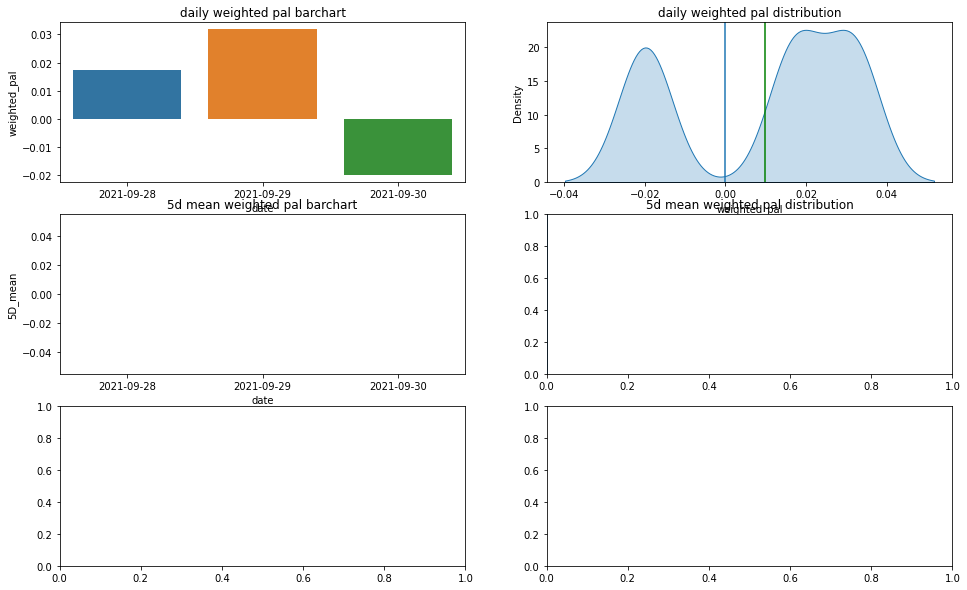

In [31]:
for a in allocator_returns:
    res = allocator_returns[a]
    fig, axs = plt.subplots(3,2, figsize=(16,10))
    print('allocator: ' + a)
    GenerateBarChart(res, 'weighted_pal', axs[0,0], 'daily weighted pal barchart')
    GenerateHistogram(res, 'weighted_pal', axs[0,1], 'daily weighted pal distribution')
    GenerateBarChart(res, '5D_mean', axs[1,0], '5d mean weighted pal barchart')
    GenerateHistogram(res, '5D_mean', axs[1,1], '5d mean weighted pal distribution')
    res['cumprod'] = (1 + res['weighted_pal']).cumprod() - 1
    GenerateLineChart(res, 'cumprod', axs[2,0], 'full cumulative product')
    GenerateHistogram(res, 'cumprod', axs[2,1], 'full cumulative product distribution')
    plt.show()